In [1]:
import os
import numpy as np
import awkward as ak

import matplotlib
import matplotlib.pyplot as plt
import mplhep as hep

from coffea.nanoevents import NanoEventsFactory, NanoAODSchema

fontsize=12
plt.style.use([hep.style.ROOT, {'font.size': fontsize}])
plt.rcParams.update({'font.size': fontsize})
plt.rcParams.update({'figure.figsize' : (6, 6)})

In [2]:
fname = "root://storage01.lcg.cscs.ch:1096//pnfs/lcg.cscs.ch/cms/trivcat/store/user/dvalsecc/ttHbb_p1j_EFT_signal_EFTcenter/SMEFTsim_topU3l_EFT_madsping_reweightall_v1/240428_205350/0000/test_eft_1.root"
events = NanoEventsFactory.from_root(
    fname,
    schemaclass=NanoAODSchema.v6,
    #metadata=metadata,
).events()

/usr/local/lib/python3.8/site-packages/coffea/nanoevents/schemas/nanoaod.py:201: RuntimeWarning: Missing cross-reference index for Electron_genPartIdx => GenPart
  warnings.warn(
/usr/local/lib/python3.8/site-packages/coffea/nanoevents/schemas/nanoaod.py:201: RuntimeWarning: Missing cross-reference index for Electron_jetIdx => Jet
  warnings.warn(
/usr/local/lib/python3.8/site-packages/coffea/nanoevents/schemas/nanoaod.py:201: RuntimeWarning: Missing cross-reference index for Electron_photonIdx => Photon
  warnings.warn(
/usr/local/lib/python3.8/site-packages/coffea/nanoevents/schemas/nanoaod.py:201: RuntimeWarning: Missing cross-reference index for FatJet_subJetIdx1 => SubJet
  warnings.warn(
/usr/local/lib/python3.8/site-packages/coffea/nanoevents/schemas/nanoaod.py:201: RuntimeWarning: Missing cross-reference index for FatJet_subJetIdx2 => SubJet
  warnings.warn(
/usr/local/lib/python3.8/site-packages/coffea/nanoevents/schemas/nanoaod.py:201: RuntimeWarning: Missing cross-reference 

In [36]:
W = events.LHEReweightingWeight

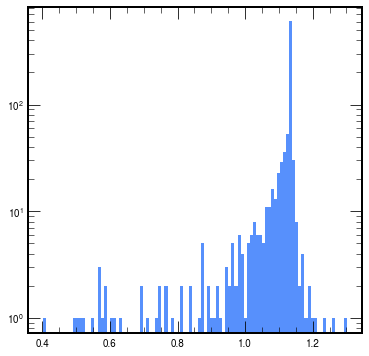

In [4]:
plt.hist(W[:,340], bins=100)
plt.yscale("log")

In [5]:
reweight_card ="ttHbb-p1j-signal-SMEFTsim-topU3l-madspin_EFTcenter_reweight_card.dat"

In [6]:
def get_wilson_vector(w_array):
    # warray starts with 1 for the SM
    w_array = [1] + w_array
    out = []
    for i in range(len(w_array)):
        for j in range(0, i+1):
            out.append(w_array[i]*w_array[j])
    return np.array(out)

In [7]:
def get_A_matrix(reweight_card):
    with open(reweight_card) as f:
        lines = f.readlines()
    
    reweightings = [ ]
    Nparams = 8
    current_block = []
    inrw = False
    for iline in range(len(lines)):
        line = lines[iline]
        if not inrw:
            if line.startswith("launch"):
                inrw = True
                continue
        else:
            # reading a reweighting block
            current_block.append(float(line.split(" ")[-1]))
            if len(current_block) == Nparams:
                # stop reading weight
                inrw = False
                reweightings.append(get_wilson_vector(current_block))
                current_block.clear()
                
    return np.stack(reweightings)
        

In [8]:
A = get_A_matrix(reweight_card)

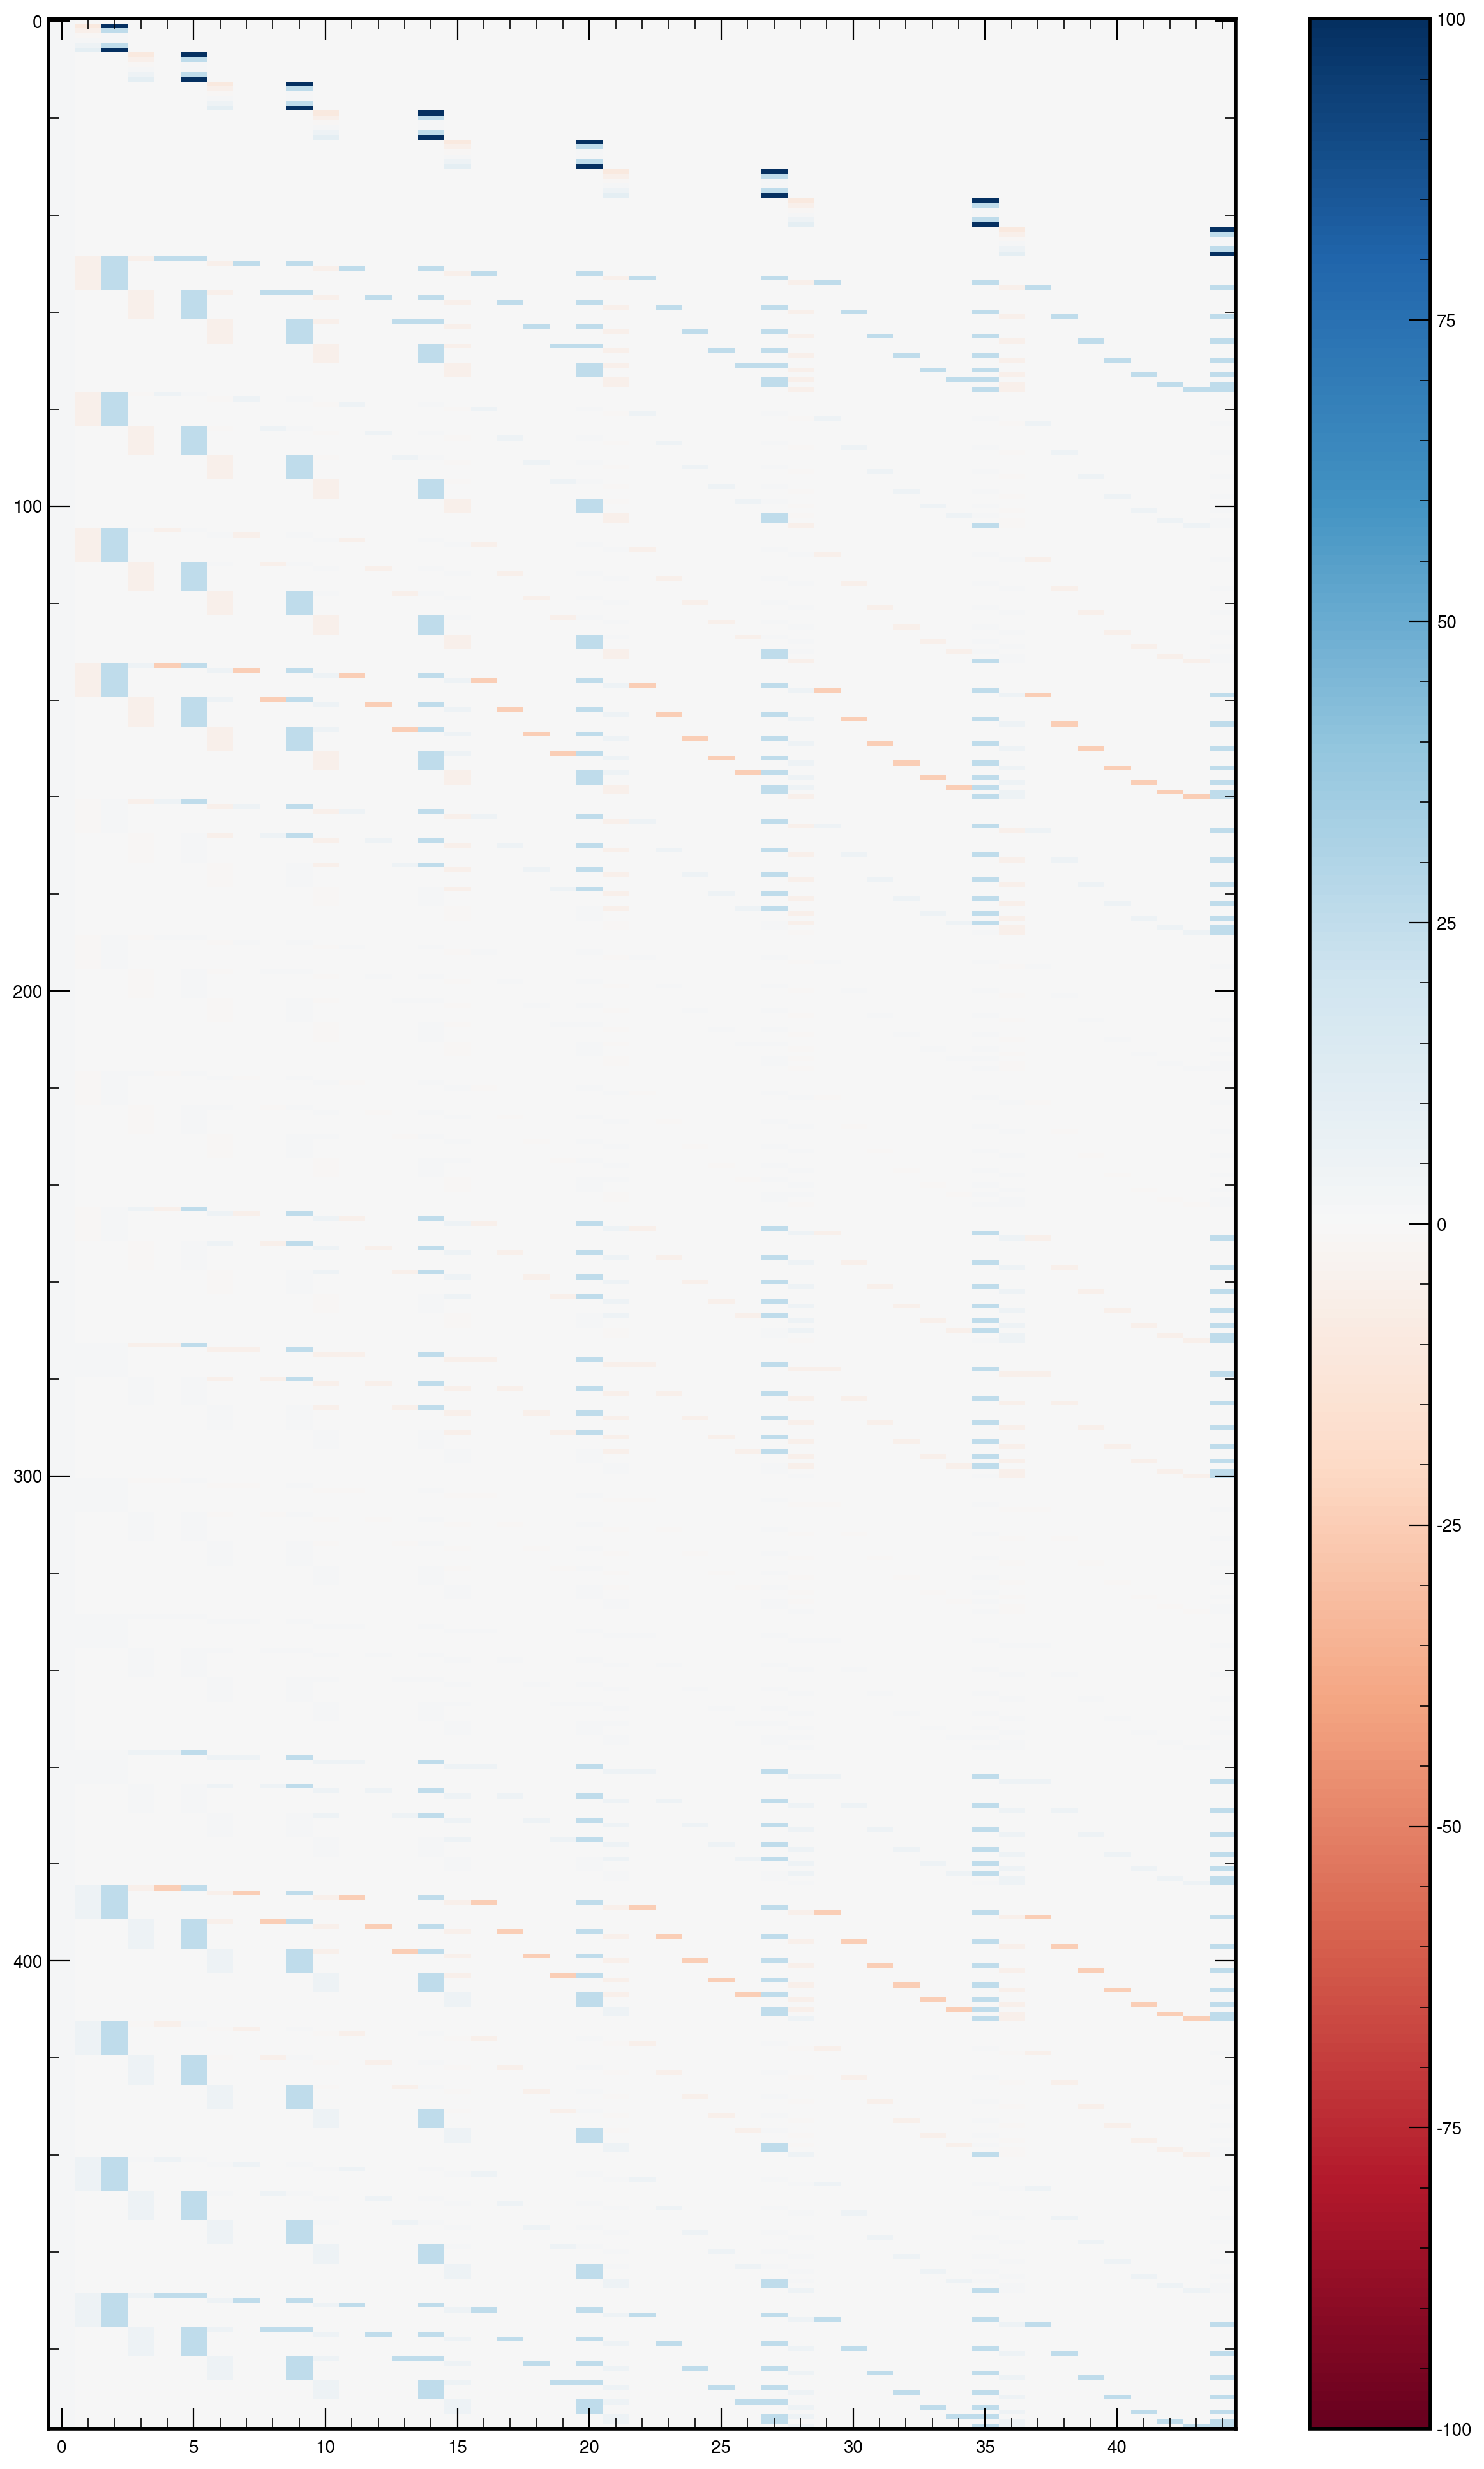

In [268]:
f = plt.figure(figsize=(15,25), dpi=200)
plt.imshow(A, aspect='auto', cmap="RdBu",vmin=-100, vmax=100)
plt.colorbar()

Use Singular Value Decomposition to decompose the A matrix in 
$$ A = U \cdot S \cdot V^T $$

In [9]:
U, S, Vh = np.linalg.svd(A, full_matrices=True)

In [10]:
U.shape

(497, 497)

In [11]:
Vh.shape

(45, 45)

In [12]:
S

array([274.85808638, 231.52537658, 231.52537658, 231.52537658,
       231.52537658, 231.52537658, 231.52537658, 231.52537658,
        52.        ,  52.        ,  52.        ,  52.        ,
        52.        ,  52.        ,  52.        ,  52.        ,
        52.        ,  52.        ,  52.        ,  52.        ,
        52.        ,  52.        ,  52.        ,  52.        ,
        52.        ,  52.        ,  52.        ,  52.        ,
        52.        ,  52.        ,  52.        ,  52.        ,
        52.        ,  52.        ,  52.        ,  52.        ,
        41.32795664,  41.32795664,  41.32795664,  41.32795664,
        41.32795664,  41.32795664,  41.32795664,  41.32795664,
        13.63936769])

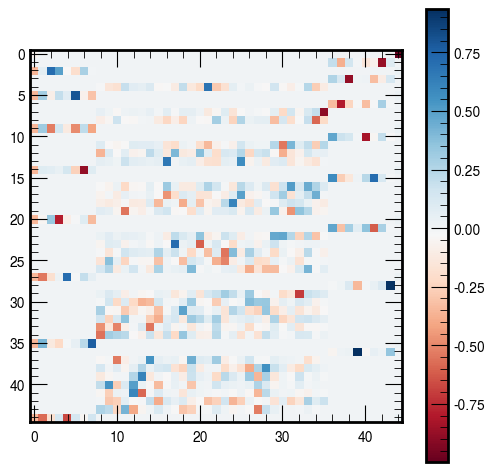

In [13]:
plt.figure(dpi=100)
plt.imshow(Vh.T, cmap="RdBu")
plt.colorbar()

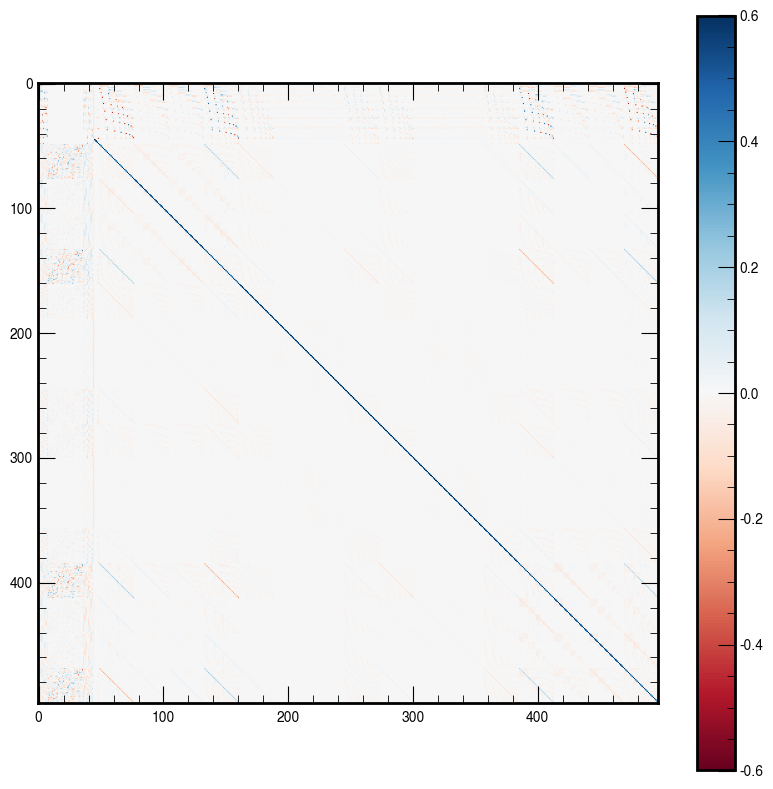

In [204]:
plt.figure(dpi=100, figsize=(10,10))
plt.imshow(U, cmap="RdBu", vmin=-0.6, vmax=0.6)
plt.colorbar()

## Inversion of A

We to invert A once for all the events so that we can compute the structure constants of each event with 
$$ Ax = W \rightarrow x = A^{-1} W $$

Using the SVD of A we can do: 
$$ x = [ V \cdot(1/S)\cdot U^T] \cdot W$$

In [14]:
ss = np.zeros((497, 45))
np.fill_diagonal(ss, 1/S)

In [15]:
Ainv = Vh.T @ ss.T @ U.T
Ainv

array([[ 5.35328280e-03, -6.79968522e-03,  2.31504079e-03, ...,
        -7.23201211e-04, -7.23201211e-04, -7.23201211e-04],
       [-4.72515955e-19, -5.85480094e-03, -2.92740047e-03, ...,
         1.06016213e-18, -3.21851351e-19,  1.24099428e-18],
       [-1.21529680e-04,  1.95285050e-03,  3.97065364e-04, ...,
        -1.71058026e-05, -1.71058026e-05, -1.71058026e-05],
       ...,
       [ 2.30598271e-20, -9.58141845e-19, -6.51775083e-19, ...,
         1.04918737e-18,  9.24556213e-03,  3.87093528e-20],
       [ 5.98860857e-20, -1.54546171e-19,  7.39247661e-21, ...,
         2.58630023e-19, -9.02746691e-19,  9.24556213e-03],
       [-1.21529680e-04,  8.73180749e-05, -6.93177414e-05, ...,
        -1.71058026e-05,  4.49277303e-04,  4.49277303e-04]])

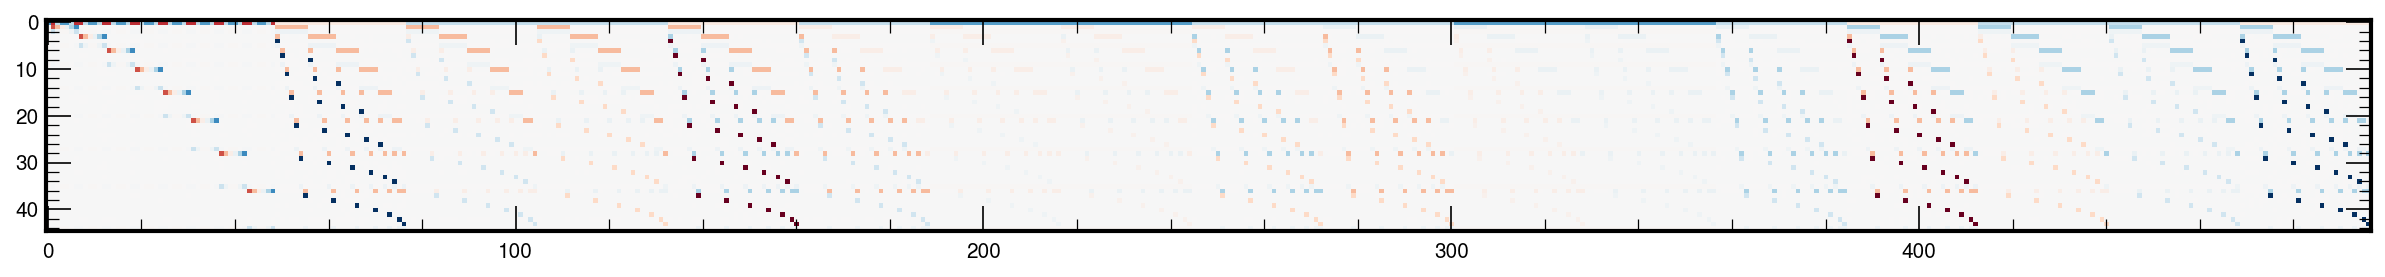

In [16]:
plt.figure(dpi=150, figsize=(20, 20))
plt.imshow(Ainv, cmap="RdBu")

# Comparison with by-event least-square inversion

The structure constanst of each event are computed from the Madgraph weights and the inversion of the Wilson coefficient matrix computed above once for all the events. 

One the structure constants vector of one event is know, we can rotate it in all the Wilson space by multiplying it 
for the correct Wilson param vector (with the same order used to construct the matrix A above)

In [47]:
S_struct = Ainv @ ak.to_numpy(W[2, :])
#S_struct2 = np.where(S_struct2 > 1e-6, S_struct2, np.zeros_like(S_struct2))
S_struct

array([ 1.12092601e+00, -1.38017739e-01,  4.32549593e-03, -5.37148683e-03,
        5.46201446e-04,  8.17027354e-03, -3.94759524e-03,  3.22533782e-04,
        5.94844480e-03,  4.08986771e-03, -1.30117332e-17, -8.70370509e-17,
        1.60470992e-17, -6.97216176e-17, -7.41520553e-08, -3.76229208e-03,
        6.65732389e-04,  1.65474344e-03,  4.22867092e-04,  7.96299337e-18,
        7.36420035e-04,  3.76229208e-03, -6.65732389e-04, -1.65474344e-03,
       -4.22867092e-04,  9.53647549e-18, -1.47287944e-03,  7.36420035e-04,
        3.30665463e-03, -6.25339485e-04, -1.20828843e-04, -2.11817273e-04,
        2.02787862e-17, -1.17675510e-03,  1.17675510e-03,  6.65948478e-04,
       -8.88590501e-19,  9.54266525e-18,  7.25387437e-18,  3.02790181e-18,
       -4.56700427e-18,  1.03107897e-18, -6.40433519e-17,  4.54232006e-18,
       -7.41520554e-08])

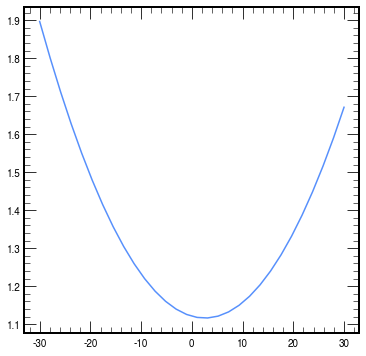

In [48]:
out = []
x =  np.linspace(-30,30,30)
for i in x:
    w = S_struct @ get_wilson_vector([0, 0, 0, 0, i, 0, 0, 0])
    out.append(w)
    
plt.plot(x, out)